<a href="https://colab.research.google.com/github/dcheney01/DeepLearning/blob/main/CancerDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to build a dense prediction model that can detect whether or not a pixel is cancerous.


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).


I implemented the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)



In [27]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [28]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
from torch.nn.parameter import Parameter
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [29]:
class CancerDataset(Dataset):
  # Make the images smaller to make the model faster (size=512)
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [30]:
class sub_module(nn.Module):
  def __init__(self, in_channels, out_channels, up_sample=False):
    super(sub_module, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
    self.up_sample = up_sample
    if up_sample:
      self.up = nn.ConvTranspose2d(out_channels, out_channels//2, 2, stride=2)

  def forward(self, input):
    x = F.relu(self.conv1(input))
    x = F.relu(self.conv2(x))
    if self.up_sample:
      x = self.up(x)
    # return x.squeeze(2).squeeze(2)
    return x


class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()
    # Down convolution blocks
    self.down_conv1 = sub_module(3, 64)
    self.down_conv2 = sub_module(64, 128)
    self.down_conv3 = sub_module(128, 256)
    self.down_conv4 = sub_module(256, 512)
    # Bottom most block
    self.bottom_block = sub_module(512, 1024, True)
    # up convolution blocks
    self.up_conv1 = sub_module(1024, 512, True)
    self.up_conv2 = sub_module(512, 256, True)
    self.up_conv3 = sub_module(256, 128, True)

    # output 2 channels (cancerous and not cancerous) and kernel size of 1
    self.out_conv1 = nn.Conv2d(128, 64, (3,3), padding=(1,1))
    self.out_conv2 = nn.Conv2d(64, 64, (3,3), padding=(1,1))
    self.out_conv3 = nn.Conv2d(64, 2, (1,1), padding=(0,0))

    self.m_pool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, input):
    d1 = self.down_conv1(input)
    d2 = self.down_conv2(self.m_pool(d1))    
    d3 = self.down_conv3(self.m_pool(d2))     
    d4 = self.down_conv4(self.m_pool(d3))     

    u = self.bottom_block(self.m_pool(d4))

    u = self.up_conv1(torch.cat((d4, u), dim=1))
    u = self.up_conv2(torch.cat((d3, u), dim=1))
    u = self.up_conv3(torch.cat((d2, u), dim=1))

    out = F.relu(self.out_conv1(torch.cat((d1, u), dim=1)))
    out = F.relu(self.out_conv2(out))  
    out = self.out_conv3(out)

    return out

In [31]:
# Initialize datasets and data loaders
train_dataset = CancerDataset('/tmp/cancer_data', train=True)
val_dataset = CancerDataset('/tmp/cancer_data', train=False)

# Grab test image and label
test_im, test_gt = val_dataset[172]
# Give test image a batch dim of 1 and put on GPU
test_im = test_im.unsqueeze(0).cuda()

# Initialize Model
model = CancerDetection()
model.cuda()

# Initialize Objective and Optimizer and other parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = nn.CrossEntropyLoss()

In [32]:
# Make sure all lists are cleared
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

test_pred = []

epoch_count = 5

import time

def scope():
  try:
    # Make sure that there is no memory that is wasted
    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)

    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=6, pin_memory=True)

    # Run your training and validation loop and collect stats
    for epoch in range(epoch_count):
      epoch_progress = tqdm(total=len(train_loader), position=0, leave=False)
      train_loss_list = []
      train_accuracy_list = []

      for batch, (x, y_truth) in enumerate(train_loader):
        gc.collect()
        x, y_truth = x.cuda(), y_truth.cuda()

        optimizer.zero_grad()
        y_hat = model(x)

        train_loss = objective(y_hat, y_truth.long())
        train_loss.backward()
        train_loss_list.append(train_loss.item())

        train_accuracy = ((y_hat).argmax(1) == y_truth).float().mean()
        train_accuracy_list.append(train_accuracy.item())

        epoch_progress.set_description('epoch:{} loss:{:.4f} accuracy:{:.6f}'.format(epoch, train_loss.item(), train_accuracy_list[-1]))
        epoch_progress.update(1)

        optimizer.step()

      # Get data from the validation dataset
      with torch.no_grad():
        val_loss_list = []
        val_accuracy_list = []

        for val, (a, b) in enumerate(val_loader):
          gc.collect()
          y_hat, val_y_truth = model(a.cuda()), b.cuda()
          
          val_loss = objective(y_hat, val_y_truth.long()).item()
          val_loss_list.append(val_loss)

          val_accuracy = ((y_hat).argmax(1) == val_y_truth).float().mean()
          val_accuracy_list.append(val_accuracy.item())

        val_accuracies.append(np.mean(val_accuracy_list))
        val_losses.append(np.mean(val_loss_list))

        train_losses.append(np.mean(train_loss_list))
        train_accuracies.append(np.mean(train_accuracy_list))  

        test_pred.append(model(test_im).cpu().detach().numpy())
        
      epoch_progress.close()
          
  except:
    __ITB__()

begin = time.time()
scope()
print("Runtime = ", time.time()-begin)  

0.13068288


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

Runtime =  2251.8505692481995


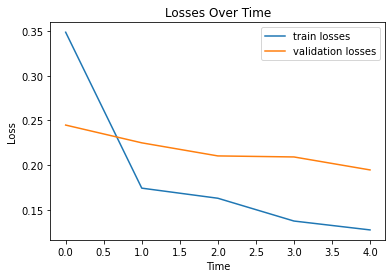

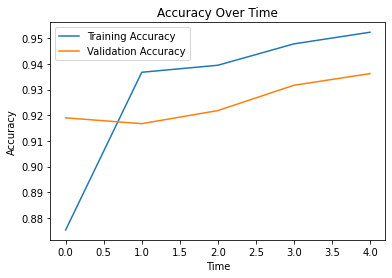

In [35]:
# Plot loss
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.title("Losses Over Time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Over Time")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

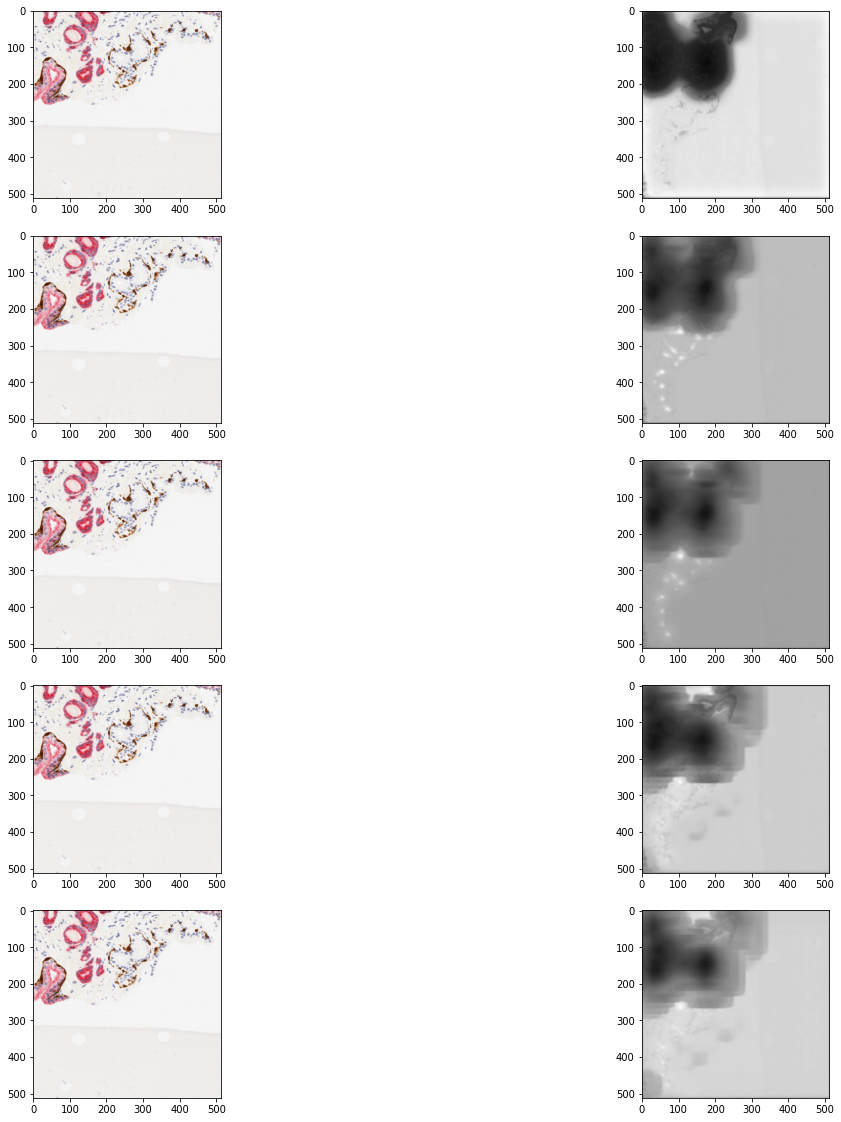

In [40]:
a = val_dataset[172][0]
a = a.swapaxes(0, -1)

output_pred = [image[0][0] for image in test_pred]
# Code for testing prediction on a specific image
# White shows the cancerous pixels

plt.subplots(5,2, figsize=(20, 20))

plt.subplot(521)
plt.imshow(a)
plt.subplot(522)
plt.imshow(output_pred[0], cmap='gray')

plt.subplot(523)
plt.imshow(a)
plt.subplot(524)
plt.imshow(output_pred[1], cmap='gray')

plt.subplot(525)
plt.imshow(a)
plt.subplot(526)
plt.imshow(output_pred[2], cmap='gray')

plt.subplot(527)
plt.imshow(a)
plt.subplot(528)
plt.imshow(output_pred[3], cmap='gray')

plt.subplot(529)
plt.imshow(a)
plt.subplot(5,2,10)
plt.imshow(output_pred[4], cmap='gray')